## Baseline Scenario

#### Fixed Split:

- Bandwidth: 25% to user equipment, 75% to sensors
- Computational power: 25% to user equipment, 75% to sensors

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt

# predefined smart city scenario
from mobile_env.scenarios.smart_city import MComSmartCity

In [2]:
env = gym.make("mobile-smart_city-smart_city_handler-v0", render_mode="rgb_array")

print(f"\nSmart city environment with {env.NUM_USERS} users, {env.NUM_SENSORS} sensors and {env.NUM_STATIONS} cells.")


Smart city environment with 5 users, 20 sensors and 1 cells.


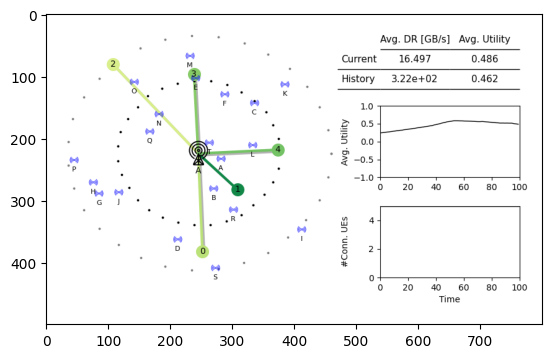

In [3]:
from IPython import display

# run the simulation for 20 time steps
done = False
obs, info = env.reset()

total_episode_reward = 0
total_reward_over_time = []  # List to store the reward at each time step

for _ in range(100):
    # here, use random dummy actions by sampling from the action space
    dummy_action = (0.25, 0.25)
    obs, reward, terminated, truncated, info = env.step(dummy_action)
    
    # accumulate total reward for the episode
    total_episode_reward += reward
    total_reward_over_time.append(total_episode_reward) 

    # render the environment
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    
plt.close()

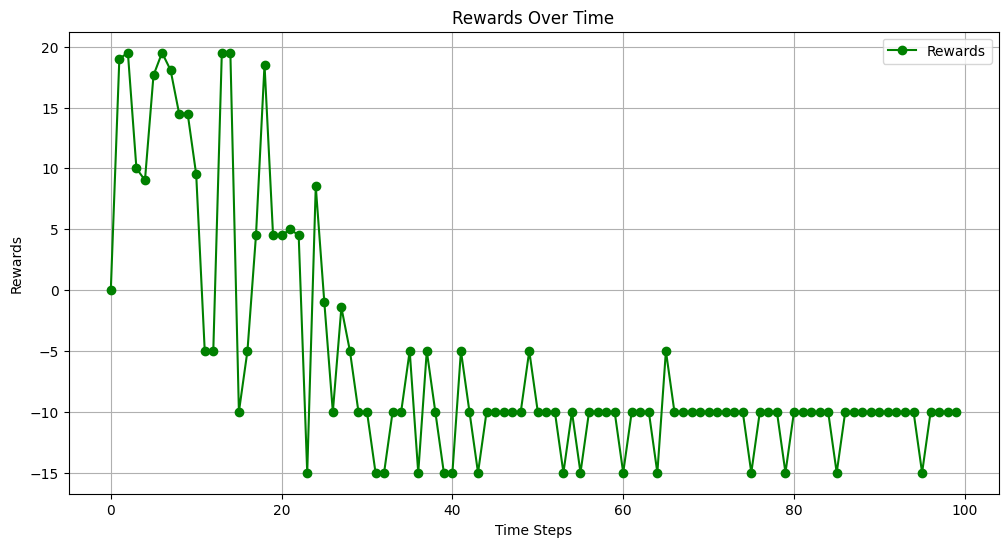

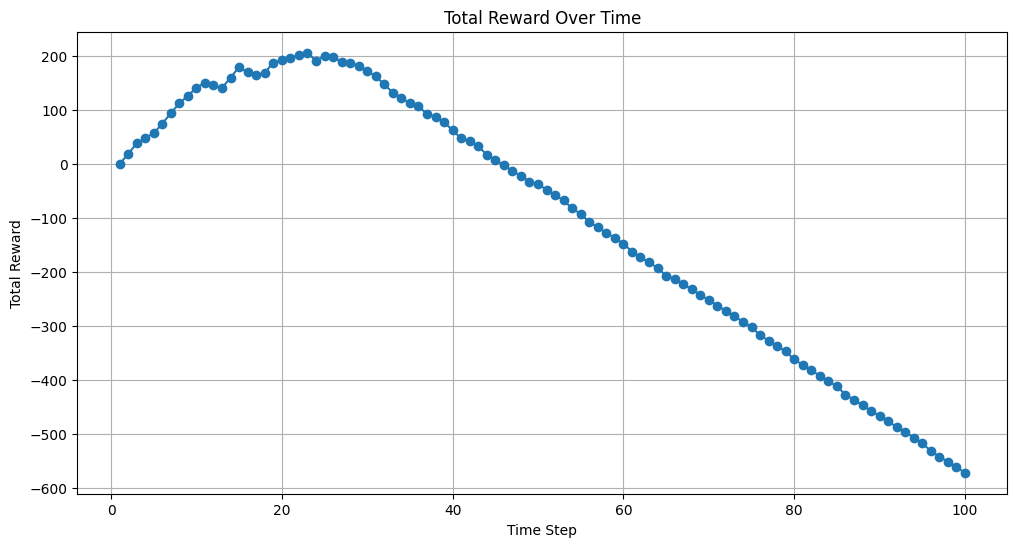

In [4]:
env.plot_rewards()

# Plot the reward over time
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(total_reward_over_time) + 1), total_reward_over_time, marker='o')
plt.title('Total Reward Over Time')
plt.xlabel('Time Step')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

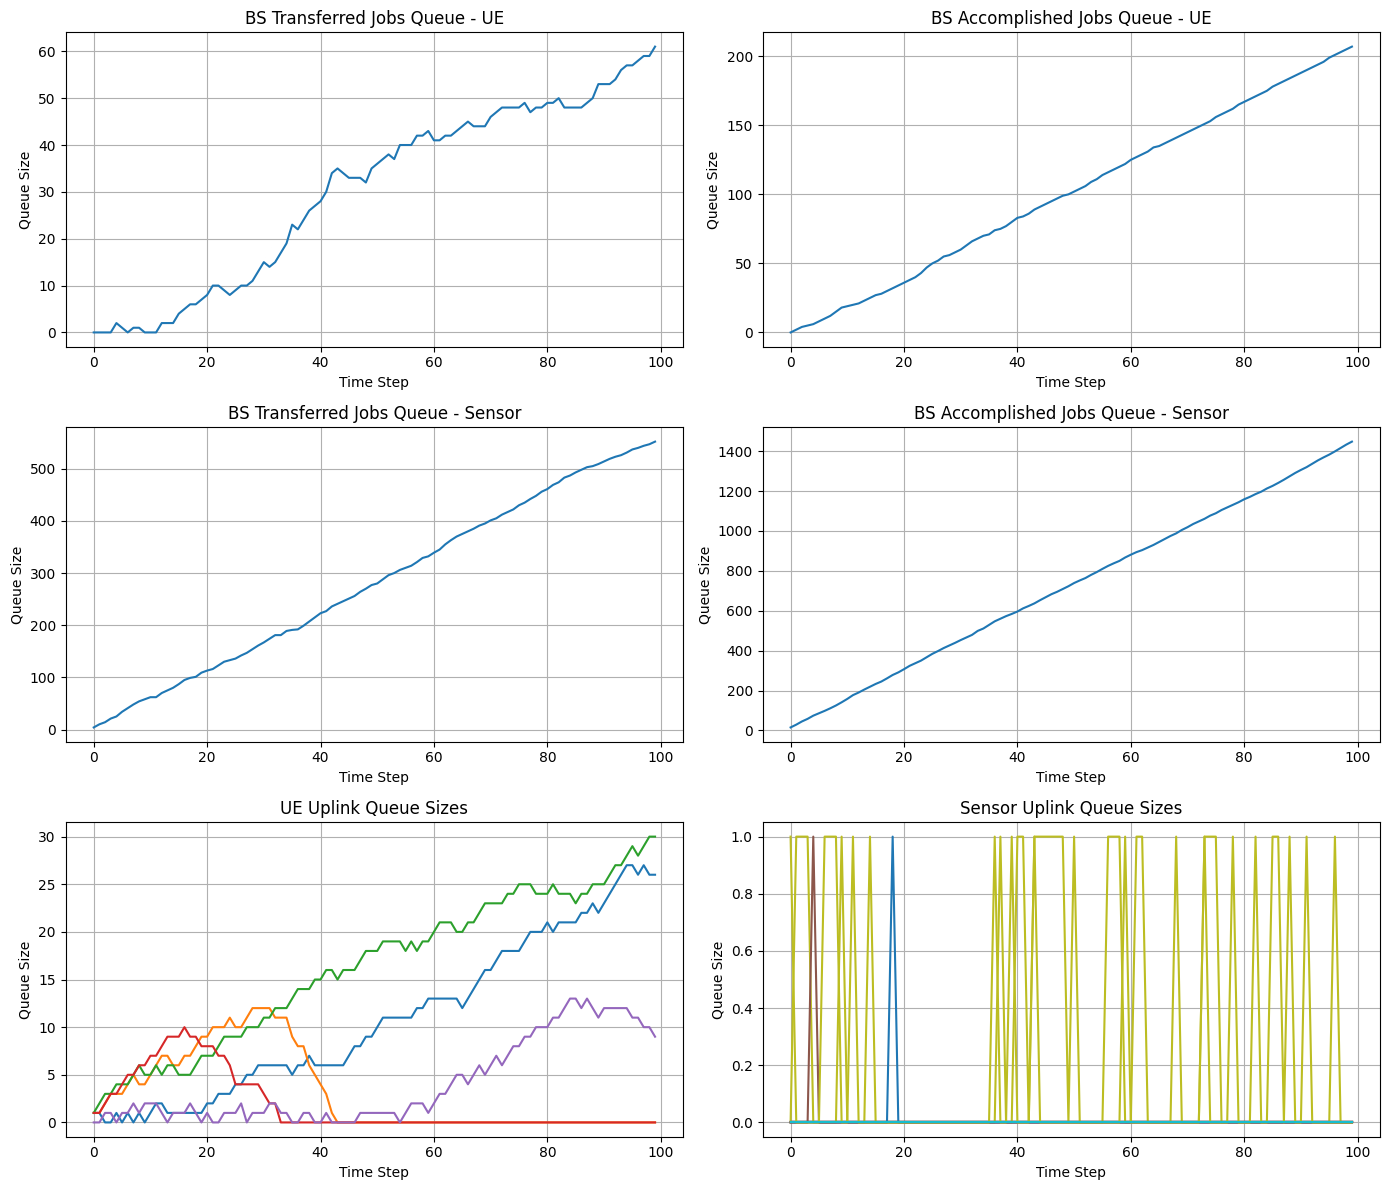

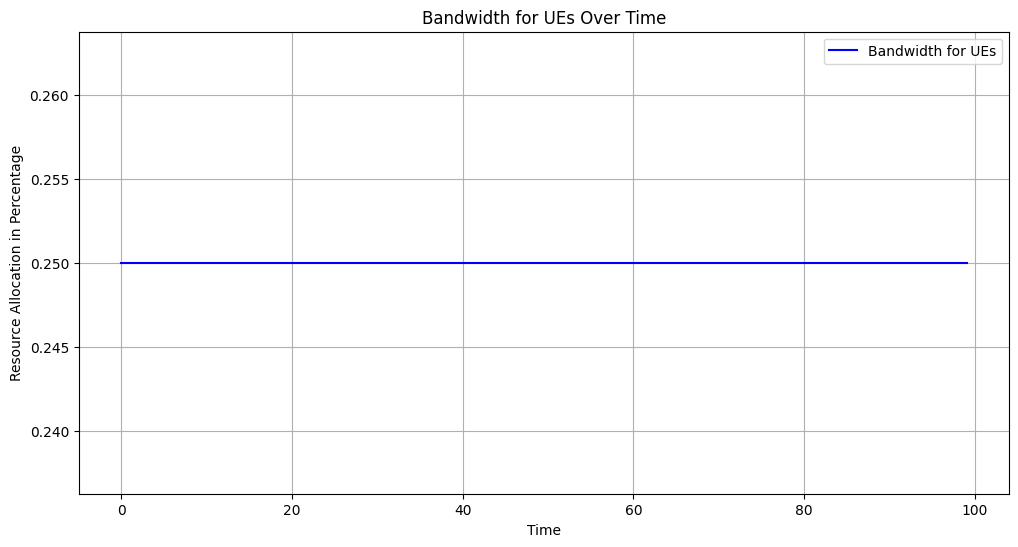

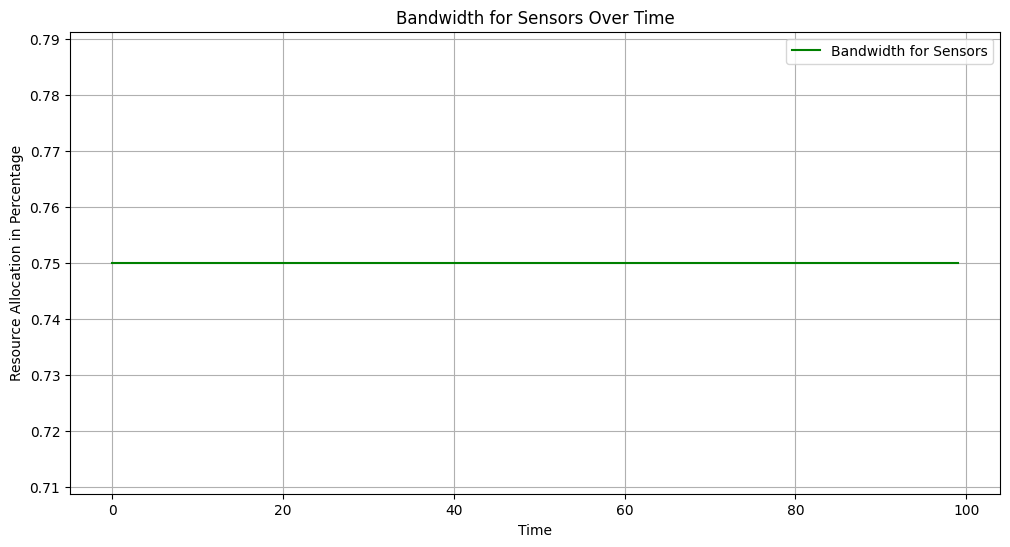

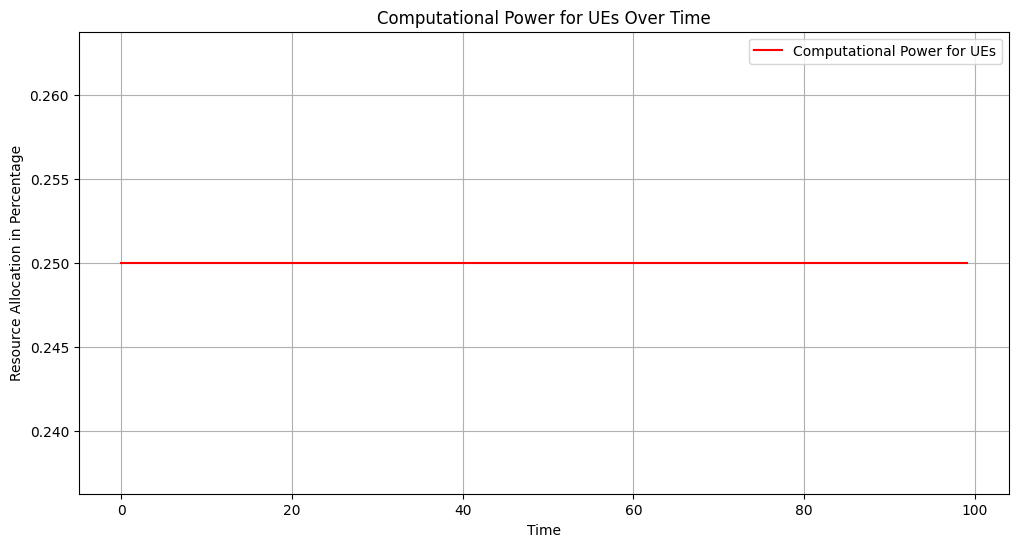

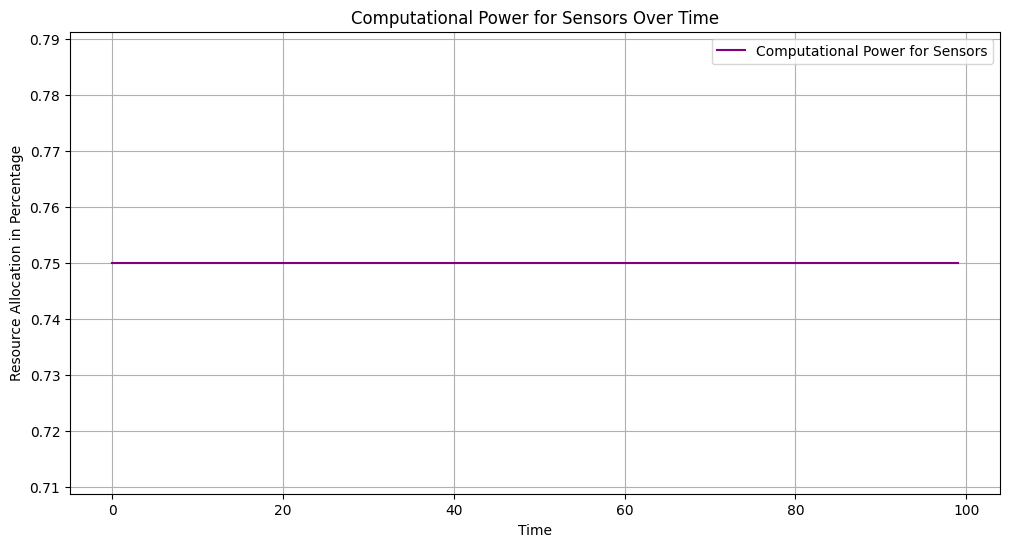

In [5]:
# Plot other environment metrics
env.plot_queue_sizes()
env.plot_resource_allocations()

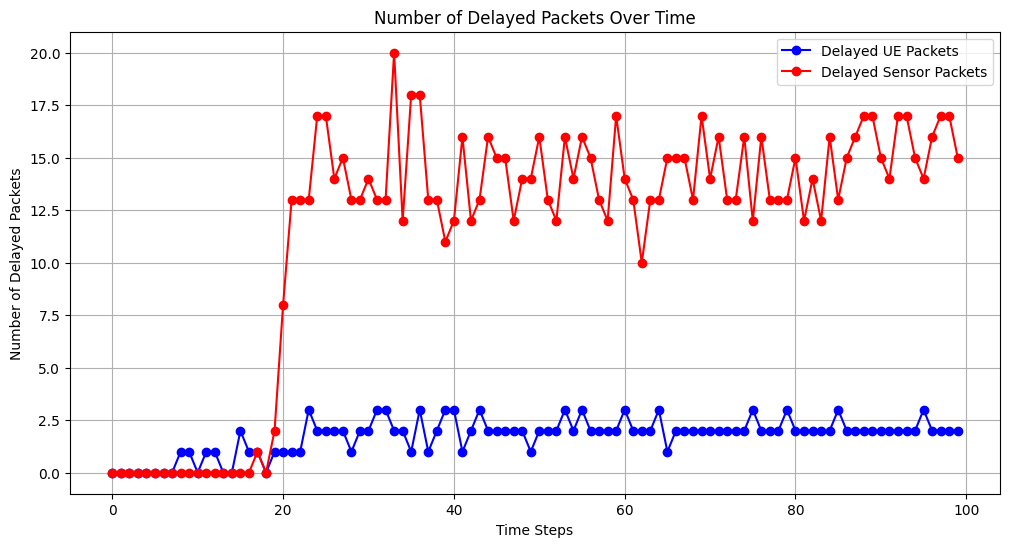

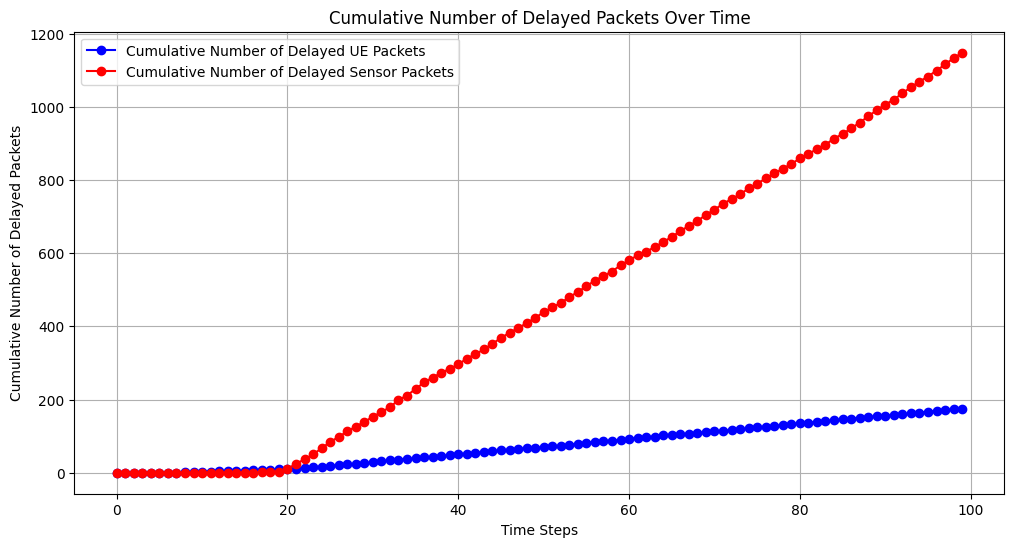

In [6]:
env.plot_delayed_packets()
env.plot_total_delayed_packets()

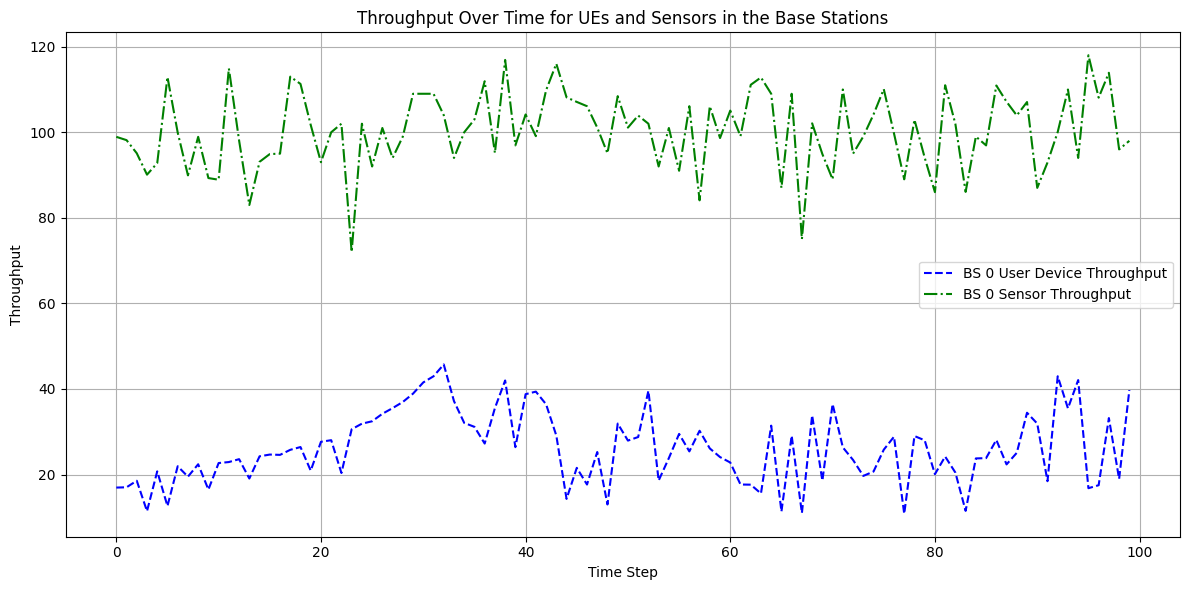

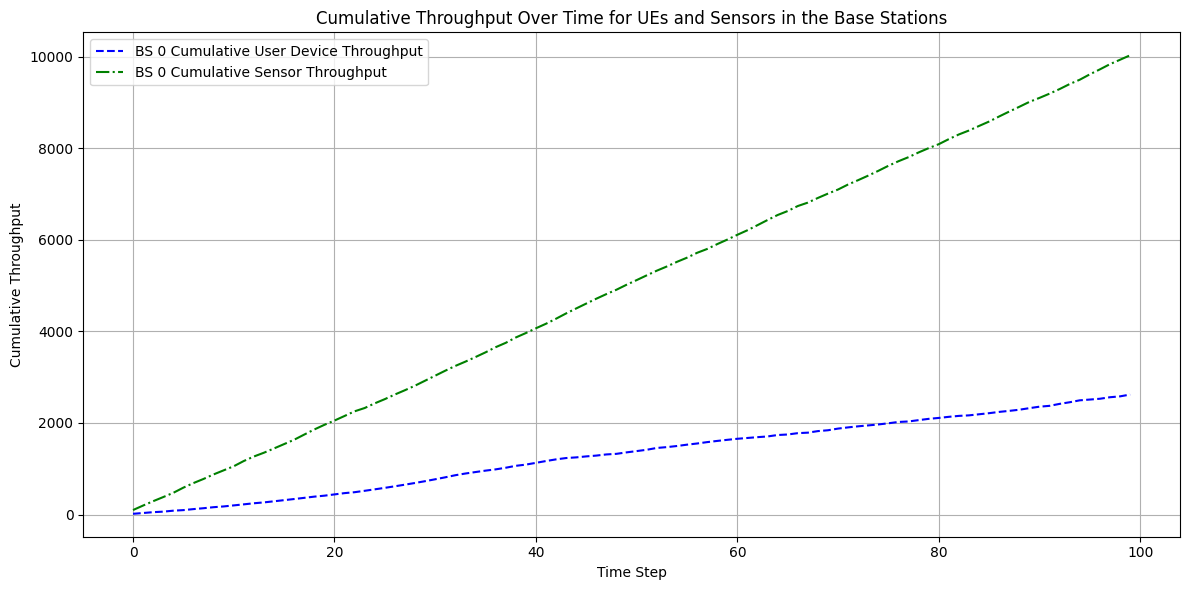

In [7]:
env.plot_throughput()
env.plot_cumulative_throughput()

In [8]:
# Run the simulation for 100 episodes
num_episodes = 100
rewards_per_episode = []  # Store total rewards for each episode

for episode in range(num_episodes):
    obs, info = env.reset()  # Reset environment for each episode
    total_episode_reward = 0  # Reset reward for the new episode
    
    print(f"Starting Episode {episode + 1}")
    
    for step in range(100):  # Limit each episode to 100 timesteps
        # Use random dummy actions
        dummy_action = (0.25, 0.25)
        obs, reward, terminated, truncated, info = env.step(dummy_action)

        # Accumulate total reward for the episode
        total_episode_reward += reward
        
        # Check if the episode is over
        if terminated or truncated:
            print(f"Episode {episode + 1} ended after {step + 1} steps.")
            break
    
    print(f"Total reward for Episode {episode + 1}: {total_episode_reward}")
    rewards_per_episode.append(total_episode_reward)  # Store total reward for this episode



Starting Episode 1
Episode 1 ended after 100 steps.
Total reward for Episode 1: -303.58725000000004
Starting Episode 2
Episode 2 ended after 100 steps.
Total reward for Episode 2: -644.3025
Starting Episode 3
Episode 3 ended after 100 steps.
Total reward for Episode 3: -443.1094375
Starting Episode 4
Episode 4 ended after 100 steps.
Total reward for Episode 4: -218.33401784804676
Starting Episode 5
Episode 5 ended after 100 steps.
Total reward for Episode 5: -588.3512499999999
Starting Episode 6
Episode 6 ended after 100 steps.
Total reward for Episode 6: -400.9
Starting Episode 7
Episode 7 ended after 100 steps.
Total reward for Episode 7: -502.60868750000003
Starting Episode 8
Episode 8 ended after 100 steps.
Total reward for Episode 8: -650.7275
Starting Episode 9
Episode 9 ended after 100 steps.
Total reward for Episode 9: -704.7061874999999
Starting Episode 10
Episode 10 ended after 100 steps.
Total reward for Episode 10: -391.3049375
Starting Episode 11
Episode 11 ended after 100

Traceback (most recent call last):
  File "/Users/elifohri/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/gk/qhk8w9w54t73z8lpmqkd7m280000gn/T/ipykernel_6590/4025770540.py", line 14, in <module>
    obs, reward, terminated, truncated, info = env.step(dummy_action)
  File "/Users/elifohri/Library/Python/3.9/lib/python/site-packages/gymnasium/wrappers/order_enforcing.py", line 56, in step
    return self.env.step(action)
  File "/Users/elifohri/Library/Python/3.9/lib/python/site-packages/gymnasium/wrappers/env_checker.py", line 49, in step
    return self.env.step(action)
  File "/Users/elifohri/Documents/mobile-env/mobile_env/core/base.py", line 651, in step
    # process data in MEC servers
  File "/Users/elifohri/Documents/mobile-env/mobile_env/core/base.py", line 835, in station_allocation
  File "/Users/elifohri/Documents/mobile-env/mobile_env/core/schedul